# Differentiable Cubical PH

This notebook reproduces topology-driven optimisation using only `cripser` + `torch`.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, update_display
import cripser

np.random.seed(0)
torch.manual_seed(0)
_INF_CUTOFF = np.finfo(np.float64).max / 2.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
print('torch:', torch.__version__)

device: cpu
torch: 2.10.0


In [15]:
# Parameters
n_iterations = 1000
learning_rate = 1e-2
noise = 0.0
maxdim = 1
filtration = 'V'

# Generate synthetic image
n, m = 30, 30
y, x = np.mgrid[-6:6:n*1j, -3:3:m*1j]
X_org = np.cos(2 * x) - np.sin(2 * y) + 0.1 * x
X_org = X_org + np.random.normal(scale=noise, size=X_org.shape)

# Set X as a learnable parameter
X = torch.tensor(X_org, dtype=torch.float32, device=device, requires_grad=True)
X = torch.nn.Parameter(X)

optimizer = torch.optim.Adam([X], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25)

losses = {'epoch': [], 'loss': [], 'lr': []}

In [16]:
progress = tqdm(range(n_iterations))
for i in progress:
    ph = cripser.compute_ph_torch(X, filtration=filtration, maxdim=maxdim)
    life_h1 = cripser.finite_lifetimes(ph, dim=1)
    loss = -life_h1.sum()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step(loss.item())

    losses['epoch'].append(i + 1)
    losses['loss'].append(float(loss.item()))
    losses['lr'].append(float(optimizer.param_groups[0]['lr']))
    progress.set_postfix(loss=f"{loss.item():.8f}", h1_count=int(life_h1.numel()))

X_opt = X.detach().cpu().numpy()
plt.close(fig)


  0%|          | 0/1000 [00:00<?, ?it/s]

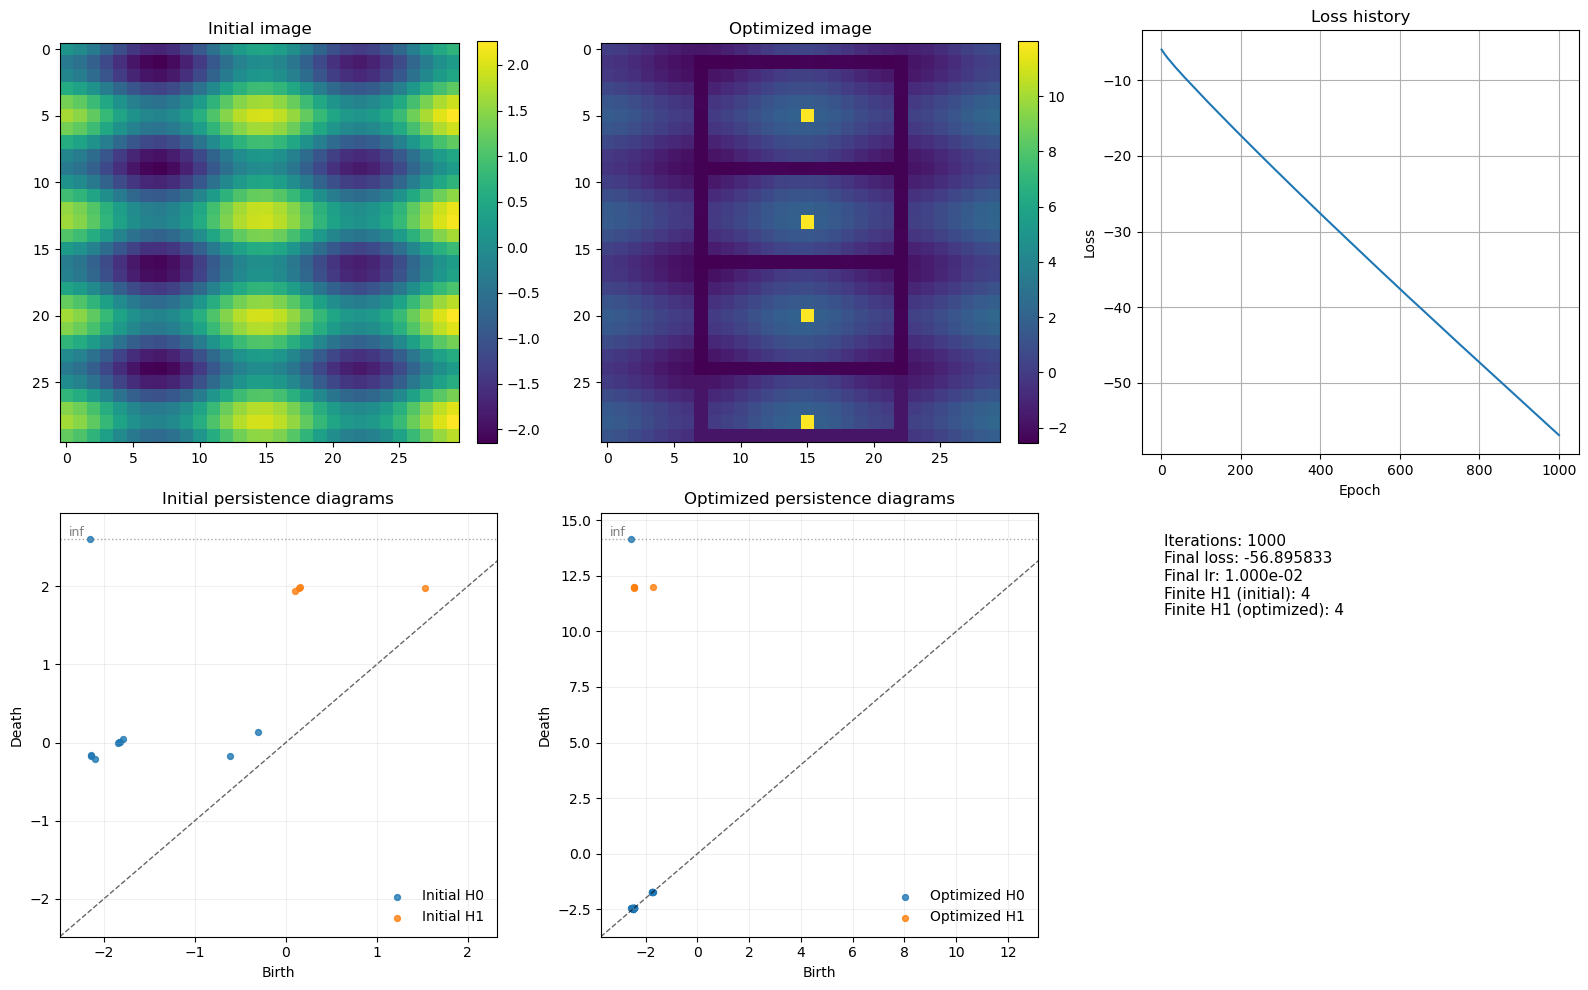

In [17]:
def compute_diagrams_np(arr, maxdim=1, filtration='V'):
    ph = cripser.compute_ph(
        np.asarray(arr, dtype=np.float64),
        maxdim=maxdim,
        filtration=filtration,
    )
    ph = np.asarray(ph, dtype=np.float64)

    if ph.size == 0:
        return [np.empty((0, 2), dtype=np.float64) for _ in range(maxdim + 1)]

    deaths = ph[:, 2].copy()
    deaths[deaths >= _INF_CUTOFF] = np.inf
    dims = ph[:, 0].astype(np.int64, copy=False)

    diagrams = []
    for k in range(maxdim + 1):
        sel = dims == k
        diagrams.append(np.column_stack((ph[sel, 1], deaths[sel])))
    return diagrams

PH_org = compute_diagrams_np(X_org, maxdim=1, filtration=filtration)
PH_opt = compute_diagrams_np(X_opt, maxdim=1, filtration=filtration)

fig, axs = plt.subplots(2, 3, figsize=(16, 10))

im0 = axs[0, 0].imshow(X_org, cmap='viridis')
axs[0, 0].set_title('Initial image')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

im1 = axs[0, 1].imshow(X_opt, cmap='viridis')
axs[0, 1].set_title('Optimized image')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

axs[0, 2].plot(losses['epoch'], losses['loss'])
axs[0, 2].set_title('Loss history')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].grid(True)

cripser.plot_diagrams(PH_org, labels=['Initial H0', 'Initial H1'], ax=axs[1, 0], show=False)
axs[1, 0].set_title('Initial persistence diagrams')

cripser.plot_diagrams(PH_opt, labels=['Optimized H0', 'Optimized H1'], ax=axs[1, 1], show=False)
axs[1, 1].set_title('Optimized persistence diagrams')

axs[1, 2].axis('off')
axs[1, 2].text(
    0.05,
    0.95,
    f'Iterations: {n_iterations}\n'
    f'Final loss: {losses["loss"][-1]:.6f}\n'
    f'Final lr: {losses["lr"][-1]:.3e}\n'
    f'Finite H1 (initial): {np.isfinite(PH_org[1][:, 1]).sum()}\n'
    f'Finite H1 (optimized): {np.isfinite(PH_opt[1][:, 1]).sum()}',
    va='top',
    fontsize=11,
)

plt.tight_layout()
plt.show()
